# 사람의 손글씨 데이터인 MNIST를 이용해 Multi Layer Perceptron (MLP) 설계할 때 Dropout 적용해보기
---
- 신경망이 지니고 있는 단점인 과적합과 Gradient Vanishing을 완화시킬 수 있는 여러 알고리즘이 나오기 시작하면서 딥러닝이 발전하게 됨. 
- Dropout은 신경망의 학습 과정 중 Layer의 노드를 랜덤하게 Drop함으로써 Generalization 효과를 가져오게 하는 테크닉임. 
- 신경망을 비롯한 많은 머신러닝 알고리즘은 행렬로 연산됨. Input Data, Weight, Hidden Layer 모두 행렬임. 
- Dropout을 적용한다는 것은 Weight Matrix에 랜덤하게 일부 Column에 0을 집어넣어 연산을 한다고 이해하면 됨. 
- Dropout을 적용할 때는 얼마나 랜덤하게 Dropout 기법을 적용할 것인지에 대한 확률 값을 지정해야 하고, 이는 Input Layer와 Hidden Layer에도 적용할 수 있음. 
- 또한 Epoch마다 랜덤하게 Dropout함. 이런 방식으로 계속 연산하면 과적합을 어느 정도 방지하는 효과를 가져옴.

In [1]:
'''1. Module Import'''

# 선형 대수와 관련된 함수를 쉽게 이용할 수 있는 모듈로, 대부분 파이썬 코드 스크립트에거 가장 자주 언급됨. 
import numpy as np

# 함수 실행 결과 산출물에 대한 수치를 쉽게 이해할 수 있도록 시각화할 수 있는 외부 모듈
import matplotlib.pyplot as plt

# 딥러닝 프레임워크 중 하나인 파이토치 기본 모듈
import torch

# PyTorch Module 중 딥러닝, 즉 인공 신경망 모델을 설계할 때 필요한 함수를 모아 놓은 모듈
import torch.nn as nn

# 'torch.nn' Module 중에서도 자주 이용되는 함수를 'F'로 지정
import torch.nn.functional as F

# 컴퓨터 비전 분야에서 자주 이용하는 'torchvision' 모듈 내 'transforms', 'datasets' 함수 import
from torchvision import transforms, datasets    # (6)

In [2]:
'''2. 딥러닝 모델을 설계할 때 활용하는 장비 확인'''

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using Pytorch version: ', torch.__version__, 'Device: ', DEVICE)

Using Pytorch version:  1.11.0 Device:  cuda


In [3]:
BATCH_SIZE = 32    # (1)
EPOCHS = 10    # (2)

- 파이썬 코드내 하이퍼파라미터를 지정할 때 보통 영어 대문자로 표기함.

(1) BATCH_SIZE: MLP 모델을 학습할 때 필요한 데이터 개수의 단위. 
- Mini-Batch 1개 단위에 대해 데이터가 32개로 구성되어 있는 것을 의미함. 
    - 좀 더 자세히 설명하면 MLP 모델을 학습할 때 32개의 데이터를 이용해 첫 번째로 학습하고, 그 다음 32개의 데이터를 이용해 두 번째로 학습함. 
    - 32개의 데이터로 1개의 Mini-Batch를 구성하고 있으며 1개의 Mini-Batch로 학습을 1회 진행함. 
    - 1개의 Mini-Batch를 이용해 학습하는 횟수를 'Iteration', 전체 데이터를 이용해 학습을 진행한 횟수를 'Epoch'이라 함. 
    - Epoch는 사용자가 정의하는 하이퍼파라미터임. 

(2) EPOCHS: Mini-Batch 1개 단위로 Back Propagation을 이용해 MLP의 가중값을 업데이트하는데, Epoch는 존재하고 있는 Mini-Batch를 전부 이용하는 횟수를 의미함. 


In [4]:
'''3. MNIST 데이터 다운로드 (train set, test set 분리하기)'''

train_dataset = datasets.MNIST(root = "../data/MNIST",    # (1)
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",    # (2)
                             train = False,
                             transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,    # (3)
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,    # (4)
                                         batch_size = BATCH_SIZE,
                                         shuffle = False)

- 흔히 데이터를 외부에서 파이썬으로 불러와 이용함. 
- 주로 엑셀 파일로 데이터를 주고받으며 이를 쉽게 처리하기 위해 Pandas Module을 이용해 'pd.read_csv()'나 'pd.read_excel()' 함수를 이용하기도 함. 
- 이외에도 'PyTorch'에서 연구용으로 자주 이용하는 데이터를 쉽게 불러올 수 있도록 구현되어 있음. 
- 'torchvision' 내 'datasets' 함수를 이용해 데이터셋을 다운로드함. 
- MLP 모델을 학습하기 위해 이용하는 학습용 데이터셋과 학습이 진행된 이후 MLP 모델의 성능을 검증하기 위해 이용하는 검증용 데이터셋을 따로 분리해 설정함. 

(1), (2) MNIST 데이터셋 다운로드
- root : 데이터가 저장될 장소 지정
- train : 대상 데이터가 학습용 데이터인인지, 검증용 데이터인지 지정
- download : 해당 데이터를 인터넷상에서 다운로드해 이용할 것인지 지정
- transform : MNIST는 이미지 데이터임. 데이터를 다운로드할 때, 이미지 데이터에 대한 기본적인 전처리를 동시에 진행할 수 있음. 
    - 여기서는 'torch' 모듈로 설계한 MLP의 Input으로 이용되기 때문에 'ToTensor()' 메서드를 이용해 'tensor' 형태로 변경함. 
    - 또한 픽셀은 0\~255 범위의 스칼라 값으로 구성되어 있는데, 이를 0\~1 범위에서 정규화 과정이 진행됨. 
    - MLP 모델이 포함된 인공 신경망 모델은 Input 데이터 값의 크기가 커질수록 불안정하거나 과적합되는 방향으로 학습이 진행될 우려가 있기 때문에 정규화 과정을 이용해 Input으로 이용하는 것을 권장함. 

(3), (4) 다운로드한 MNIST 데이터셋을 Mini-Batch 단위로 분리해 지정함. 
- 여기서는 Mini-Batch 단위를 이용해 MLP 모델을 학습시킬 것이므로 Mini-Batch 별로 데이터를 묶어 단위를 맞추고자 함. 
- 이미지 데이터 1개 각각을 이용해 MLP 모델을 학습시키는 것이 아니라 이미지 데이터를 Batch Size만큼, 즉 32개만큼 묶어 1개의 Mini-Batch를 구성하는 것을 'DataLoader' 함수를 이용해 진행할 수 있음.
    - dataset : Mini-Batch 단위로 할당하고자 하는 데이터셋을 지정
    - batch_size : Mini-Batch 1개 단위를 구성하는 데이터의 개수를 지정함. 
    - shuffle : 데이터의 순서를 섞고자 할 때 이용함. 잘못된 방향으로 학습하는 것을 방지하기 위해 데이터 순서를 섞는 과정을 진행

In [5]:
'''4. 데이터 확인하기 (1)'''
for (X_train, y_train) in train_loader: 
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


- 다운로드한 후 Mini-Batch 단위로 할당한 데이터의 개수와 형태 확인
- X_train : 32개의 이미지 데이터가 1개의 Mini-Batch를 구성하고 있고 가로 28개, 세로 28개의 픽셀로 구성되어 있으며 채널이 1이므로 그레이스케일로 이루어진, 흑백으로 이루어진 이미지 데이터라는 것을 확인할 수 있음. 
- y_train : 32개의 이미지 데이터 각각에 label 값이 1개씩 존재하기 때문에 32개의 값을 갖고 있다는 것을 확인할 수 있음. 

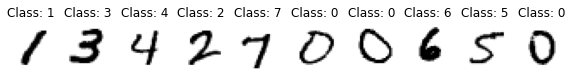

In [6]:
'''5. 데이터 확인하기 (2)'''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
'''6. MLP(Multi Layer Perceptron) 모델 설계하기'''

# PyTorch Module 내에 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Moudle 클래스를 상속받는 Net 클래스를 정의
# nn.Module 클래스를 상속받았을 때 nn.Module 클래스의 함수를 그대로 이용할 수 있기 때문에 새로운 딥러닝 모델을 설계할 때 자주 이용됨. 
class Net(nn.Module):
    
    # Net 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의해주는 메서드
    def __init__(self):
        
        # nn.Moudle 내에 있는 메서드를 상속받아 이용
        super(Net, self).__init__()
        
        # 첫 번째 Fully Connected Layer를 정의함. 
        # MNIST 데이터를 Input으로 사용하기 위해 28 * 28 * 1 크기의 노드 수를 설정한 후
        # 두 번째 Fully Connected Layer의 노드 수를 512개로 설정할 것이기 때문에 Output의 노드 수는 512개로 설정함. 
        self.fc1 = nn.Linear(28 * 28, 512)
        
        # 두 번재 Fully Connected Layer를 정의함. 
        # 첫 번째 Fully Connected Layer의 output 크기인 512 크기의 벡터 값을 Input을 사용하기 위해 노드 수를 512개로 설정하고
        # 세 번재 Fully Connected Layer의 노드 수를 256으로 설정할 것이기 때문에 Output의 노드 수를 256개로 설정함. 
        self.fc2 = nn.Linear(512, 256)
        
        # 세 번째 Fully Connected Layer를 정의함. 
        # 두 번째 Fully Connected Layer의 Output 크기인 256 크기의 벡터 값을 Input으로 사용하기 위한 노드 수를 256개로 설정하고
        # Output으로 사용하기 위한 노드 수를 10개로 설정함. 
        # 0부터 9까지 총 10가지 클래스를 표현하기위한 Label 값은 원-핫 인코딩으로 표현됨. 
        self.fc3 = nn.Linear(256, 10)
        
        # 몇 퍼센트의 노드에 대해 가중값을 계산하지 않을 것인지를 명시해주는 부분
        self.dropout_prob = 0.5
    
    # Net 클래스를 이용해 설계한 MLP 모델의 Forward Propagation을 정의
    # 즉, 설계한 MLP 모델에 데이터를 입력했을 때 Output을 계산하기까지의 과정을 나열한 것을 의미
    def forward(self, x):
        
        # MLP 모델은 1차원의 벡터 값을 입력으로 받을 수 있음. 하지만 MNIST 이미지 데이터는 크기가 28 * 28인 2차원 데이터임. 
        # 따라서 View 메서드를 이용해 784 크기의 1차원 데이터로 변환해 진행해야 함. 
        # 이를 2차원의 데이터를 1차원으로 펼친다고 표현하며 Flatten한다라고 표현하기도 함. 
        x = x.view(-1, 28 * 28)    # -1은 다른 차원으로부터 추론된다고 함. 
        
        # __init__() method를 이용해 정의한 첫 번재 Fully Connected Layer에 1차원으로 펼친 이미지 데이터를 통과시킴. 
        x = self.fc1(x)
        
        # PyTorch Module 중 인공 신경망(Neural Network) 설계에 유용한 함수를 모아놓은 torch.nn.functional 내에 정의된
        # 비선형 함수인 sigmoid()를 이용해 두 번째 Fully Connected Layer의 Input으로 계산함. 
        x = F.sigmoid(x)
        
        # 각 sigmoid() 함수의 결고값에 대해 Droppout을 적용하는 부분
        # training = self.training은 학습 상태일 때와 검증 상태에 따라 다르게 적용되기 위해 존재하는 파라미터임. 
        # Dropout은 학습 과정 속에서 랜덤으로 노드를 선택해 가중값이 업데이트되지 않도록 조정하지만, 
        # 평가 과정 속에서는 모든 노드를 이용해 Output을 계산하기 때문에 학습 상태와 검증 상태에서 다르게 적용되어야 함. 
        x = F.dropout(x, training = self.training, p = self.dropout_prob) 
        
        # __init__() method를 이용해 정의한 두 번째 Fully Connected Layer에 앞에서 sigmoid()로 계산된 결과를 통과시킴. 
        x = self.fc2(x)
        
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob) 
        x = self.fc3(x)
        
        # torch.nn.functional 내의 log.softmax()를 이용해 최종 Output 계산
        # 총 10가지 경우의 수 중 하나로 분류하는 일을 수행하기 때문에 softmax를 이용해 확률 값을 계산함. 
        # log_softmax()를 이용하는 이유는 MLP 모델이 Back Propagation 알고리즘을 이용해 학습을 진행할 때
        # Loss 값에 대한 Gradient 값을 좀 더 원활하게 계산할 수 있기 때문임. 
        # Log 함수 그래프의 기울기가 부드럽게 변화하는 것을 상상해보면 직관적으로 이해할 수 있다고 함. 
        x = F.log_softmax(x, dim = 1)
        return x

- torch 모듈을 이용해 본격적으로 MLP를 설계하는 단계임. 

In [8]:
'''7. Optimizer, Objective Function 설정하기'''

model = Net().to(DEVICE)

# Back Propagation을 이용해 파라미터를 업데이트할 때 이용하는 Optimizer 정의
# 이 예제에서는 SGD 알고리즘을 이용해 파라미터를 업데이트할 때 반영될 LR을 0.01, 
# Optimizer의 관성을 나타내는 momentum을 0.5로 설정함. 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

# MLP 모델의 output 값과 계산될 Label 값은 Class를 표현하는 원-핫 인코딩 값임. 
# MLP 모델의 output 값과 원-핫 인코딩 값과의 Loss는 CrossEntropy를 이용해 계산하기 위해
# criterion은 'nn.CrossEntropyLoss()'로 설정함. 
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
'''8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의'''

def train(model, train_loader, optimizer, log_interval):
    
    # 기존에 정의한 MLP 모델을 학습 상태로 지정
    model.train()
    
    # 기존에 정의한 'train_loader'에는 학습에 이용되는 이미지 데이터와 레이블 데이터가 Mini-Batch 단위로 묶여 저장되어 있음. 
    # 해당 'train_loader' 내에 Mini-Batch 단위로 저장된 데이터를 순서대로 이용해 MLP 모델을 학습
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        # 기존에 정의한 장비에 이미지 데이터와 레이블 데이터를 할당할 경우, 과거에 이용한 Mini-Batch 내에 있는
        # 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss의 Gradient 값이 optimizer에 할당되어 있으므로
        # optimizer의 Gradient를 초기화함. 
        optimizer.zero_grad()
        
        # 장비에 할당한 이미지 데이터를 MLP 모델의 Input으로 이용해 Output을 계산
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        
        # 각 파라미터에 할당된 Gradient 값을 이용해 파라미터 값을 업데이트함. 
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100. * batch_idx / len(train_loader),
            loss.item()))

- MLP 모델을 설계했으므로 기존에 정의한 이미지 데이터와 레이블 데이터를 이용해 MLP 모델을 학습하는 train 함수를 정의함. 
- 다음은 학습의 진행 과정을 모니터링하기 위해 출력하는 코드임. 

In [10]:
'''9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의'''

def evaluate(model, test_loader):
    
    # 학습 과정 또는 학습이 완료된 MLP 모델을 학습 상태가 아닌, 평가 상태로 지정
    model.eval()
    
    # 기존에 정의한 'test_loader' 내의 데이터를 이용해 Loss 값을 계산하기 위해 'test_loss'를 0으로 임시 설정
    test_loss = 0
    
    # 학습 과정 또는 학습이 완료된 MLP 모델이 올바른 Class로 분류한 경우를 세기 위해 correct = 0으로 임시 설정
    correct = 0
    
    # MLP 모델을 평가하는 단계에서는 Gradient를 통해 파라미터 값이 업데이트되는 현상을 방지하기 위해
    # 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제함. 
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            
            # MLP 모델의 Output 값은 크기가 10인 벡터임. 
            # 계산된 벡터 값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단함. 
            prediction = output.max(1, keepdim = True)[1]
            
            # MLP 모델이 최종으로 에측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면 correct에 더해 올바르게 예측한 횟수를 저장
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    
    # 현재까지 계산된 'test_loss'의 값을 'test_loader' 내에 존재하는 Mini-Batch 개수만큼 나눠 평균 Loss 값으로 계산함. 
    test_loss /= len(test_loader.dataset)
    
    # 'test_loader' 데이터 중 얼마나 맞췄는지를 계산해 정확도를 계산
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- MLP 모델 학습 과정 또는 학습이 완료된 상태에서 MLP 모델의 성능을 평가하기 위해 'evaluate' 함수를 정의함. 

In [11]:
'''10. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기'''

for Epoch in range(1, EPOCHS + 1):
    
    # 정의한 train 함수 실행
    # model은 기존에 정의한 MLP 모델, train_loader는 학습 데이터, optimizer는 SGD,
    # log_interval은 학습이 진행되면서 Mini-Batch의 Index를 이용해 과정을 모니터링할 수 있도록 출력하는 것을 의미함. 
    train(model, train_loader, optimizer, log_interval = 200)
    
    # 각 Epoch별로 출력되는 Loss 값과 accuracy 값을 계산함. 
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
         format(Epoch, test_loss, test_accuracy))

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.365543
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.350654
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 2.340778
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 2.368758
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 2.339110
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 2.281949
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 2.299628
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 2.265604
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 2.269531
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 2.291203

[EPOCH: 1], 	Test Loss: 0.0714, 	Test Accuracy: 14.84 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 2.262770
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 2.244600
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 2.295525
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 2.246093
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 2.234591
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 2.235462
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 2.253095
Train Epoch: 2 [448

- 이론상 Dropout을 적용했을 때 일반화가 강해져 Test Accuracy가 높아지는 결과가 기대되지만, 이는 학습 데이터셋과 검증 데이터셋의 피처 및 레이블의 분포 간 많은 차이가 있을 때 유효하게 작용함. 
- MNIST 데이터셋은 학습 데이터와 검증 데이터 간 많은 차이가 발생하지 않기 때문에 오히려 성능이 조금 하락할 수도 있음. 
- 하지만 Epoch을 늘려 추가로 학습을 진행하면 성능이 좋아지는 경향이 있음. 
- Dropout은 보통 ReLU() 비선형 함수와 잘 어울림. 
- 바로 다음 예제에서 비선형 함수를 sigmoid()에서 ReLU()로 변경했을 때 Dropout의 효과를 살펴볼 예정.

## Reference
---
- 파이썬 딥러닝 파이토치 - 이경택, 방성수, 안상준